# 🫁💾 **Machine Learning Approach to Diagnose Lung Cancer**  
### Using Explainable Artificial Intelligence (XAI) and Active Learning Techniques  

---

#### 📘 Artificial Intelligence — Academic Year 2025/2026  
#### 🧬 Master in Computational Biology | University of Coimbra

---

**Authors:**  
- Guilherme Cardoso — nº 2021226995  
- Julieta Carmo — nº 2021228206  
- Maria Inês Gomes — nº 2021222220  

---

*🩺 This notebook presents a machine learning-based approach for the early diagnosis of lung cancer, integrating Explainable AI (XAI) and Active Learning to improve model interpretability and diagnostic precision.*

In [ ]:
# Importing libraries
import random
import warnings
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from copy import deepcopy
from sklearn.cluster import KMeans
import shap

# Ignoring specific warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Ensuring reproductibility of results
np.random.seed(100)
random.seed(100)

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=7ead280a61d729a9defd2b3a3781d658b3c0cb4906fdac0f2d1936867e0cc381
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


#### **Loading Dataset, Analysis and Preprocessing**
---

In [ ]:
# Loading the dataset
df = pd.read_csv("survey lung cancer.csv")

# Displaying first few rows and basic information
print(df.head())
print("\nDataframe shape:", df.shape)

# Checking for duplicates
print("\nNumber of duplicate rows:", df.duplicated().sum())

# Removing duplicate rows
df = df.drop_duplicates(ignore_index=True)
print("Duplicate rows removed. New dataset shape:", df.shape)

# Checking for missing (null) values
print("\nTotal missing values in dataset:", df.isnull().sum().sum())

# Displaying dataset information
print("\nDataset information:\n")
df.info()

print("\nDataset statistics:", df.describe())
# 'Gender' and 'Lung Cancer' are objects so they need to be converted to numeric values.


  GENDER  AGE  SMOKING  YELLOW_FINGERS  ANXIETY  PEER_PRESSURE  \
0      M   69        1               2        2              1   
1      M   74        2               1        1              1   
2      F   59        1               1        1              2   
3      M   63        2               2        2              1   
4      F   63        1               2        1              1   

   CHRONIC DISEASE  FATIGUE   ALLERGY   WHEEZING  ALCOHOL CONSUMING  COUGHING  \
0                1         2         1         2                  2         2   
1                2         2         2         1                  1         1   
2                1         2         1         2                  1         2   
3                1         1         1         1                  2         1   
4                1         1         1         2                  1         2   

   SHORTNESS OF BREATH  SWALLOWING DIFFICULTY  CHEST PAIN LUNG_CANCER  
0                    2                      

#### **Plot Feature Distribution**
---

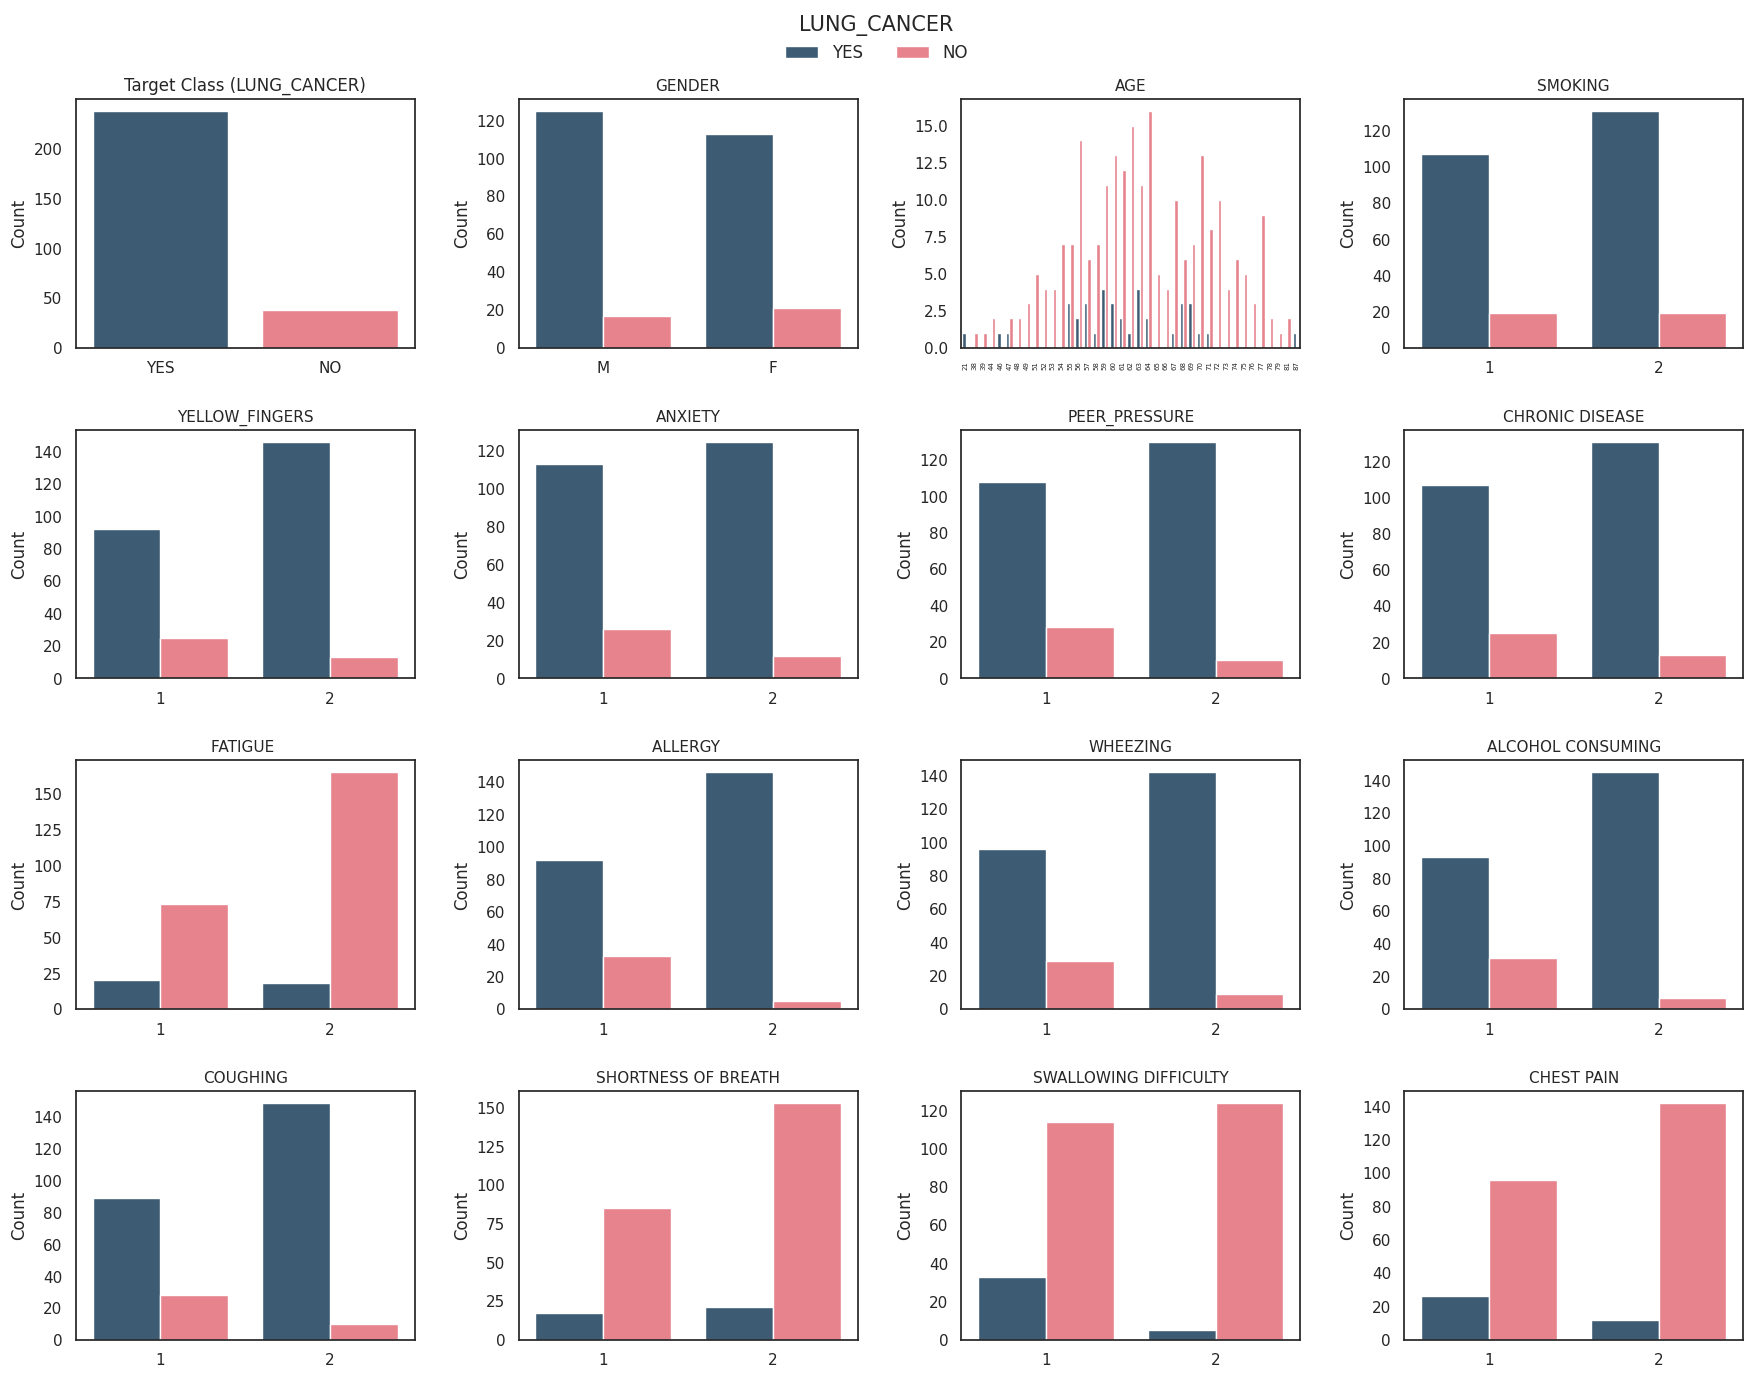

In [ ]:
sns.set(style="white")
palette = ["#355C7D", "#F67280"]

fig, axes = plt.subplots(4, 4, figsize=(18, 14))
axes = axes.flatten()

# Distribution of target variable (Lung Cancer)
sns.countplot(
    x="LUNG_CANCER",
    hue="LUNG_CANCER",
    data=df,
    ax=axes[0],
    palette=palette,
    legend=False,
)
axes[0].set_title("Target Class (LUNG_CANCER)", fontsize=12)
axes[0].set_xlabel("")
axes[0].set_ylabel("Count")

# Columns to analyze
cols = [
    "GENDER",
    "AGE",
    "SMOKING",
    "YELLOW_FINGERS",
    "ANXIETY",
    "PEER_PRESSURE",
    "CHRONIC DISEASE",
    "FATIGUE ",
    "ALLERGY ",
    "WHEEZING",
    "ALCOHOL CONSUMING",
    "COUGHING",
    "SHORTNESS OF BREATH",
    "SWALLOWING DIFFICULTY",
    "CHEST PAIN",
]

# Plot
for i, col in enumerate(cols, start=1):
    sns.countplot(x=col, hue="LUNG_CANCER", data=df, ax=axes[i], palette=palette)
    axes[i].set_title(col, fontsize=11)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Count")
    axes[i].legend_.remove()  # remove duplicate legends

    # Adjust x-axis for AGE column to avoid overlap
    if col == "AGE":
        axes[i].tick_params(axis="x", rotation=90, labelsize=5)

# Hide blank subplots
for ax in axes[len(cols) + 1 :]:
    ax.set_visible(False)

# Create legend
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="LUNG_CANCER",
    loc="upper center",
    ncol=2,
    fontsize=12,
    title_fontsize=15,
    frameon=False,
)

plt.tight_layout(pad=2, rect=[0, 0, 1, 0.97])
plt.show()


#### **Feature Encoding**
---

In [ ]:
# Object-type/categorical variables were encoded to 0 or 1.
# In order to mantain the same scale, all numeric variables were also converted to 0 or 1.

# Encode only categorical columns to numeric
le = preprocessing.LabelEncoder()
df["GENDER"] = le.fit_transform(df["GENDER"])            # M -> 1, F -> 0
df["LUNG_CANCER"] = le.fit_transform(df["LUNG_CANCER"])  # YES -> 1, NO -> 0

# Convert numeric columns with 1-2 to 0-1 to match previous encoding
df = df.apply(
    lambda col: col.replace({1: 0, 2: 1}) if set(col.unique()) == {1, 2} else col
)

# Display first few rows and dataset information to check encoding
print(df.head())
print("\nDataset information:\n")
df.info()

   GENDER  AGE  SMOKING  YELLOW_FINGERS  ANXIETY  PEER_PRESSURE  \
0       1   69        0               1        1              0   
1       1   74        1               0        0              0   
2       0   59        0               0        0              1   
3       1   63        1               1        1              0   
4       0   63        0               1        0              0   

   CHRONIC DISEASE  FATIGUE   ALLERGY   WHEEZING  ALCOHOL CONSUMING  COUGHING  \
0                0         1         0         1                  1         1   
1                1         1         1         0                  0         0   
2                0         1         0         1                  0         1   
3                0         0         0         0                  1         0   
4                0         0         0         1                  0         1   

   SHORTNESS OF BREATH  SWALLOWING DIFFICULTY  CHEST PAIN  LUNG_CANCER  
0                    1               

#### **Correlation Matrix**
---

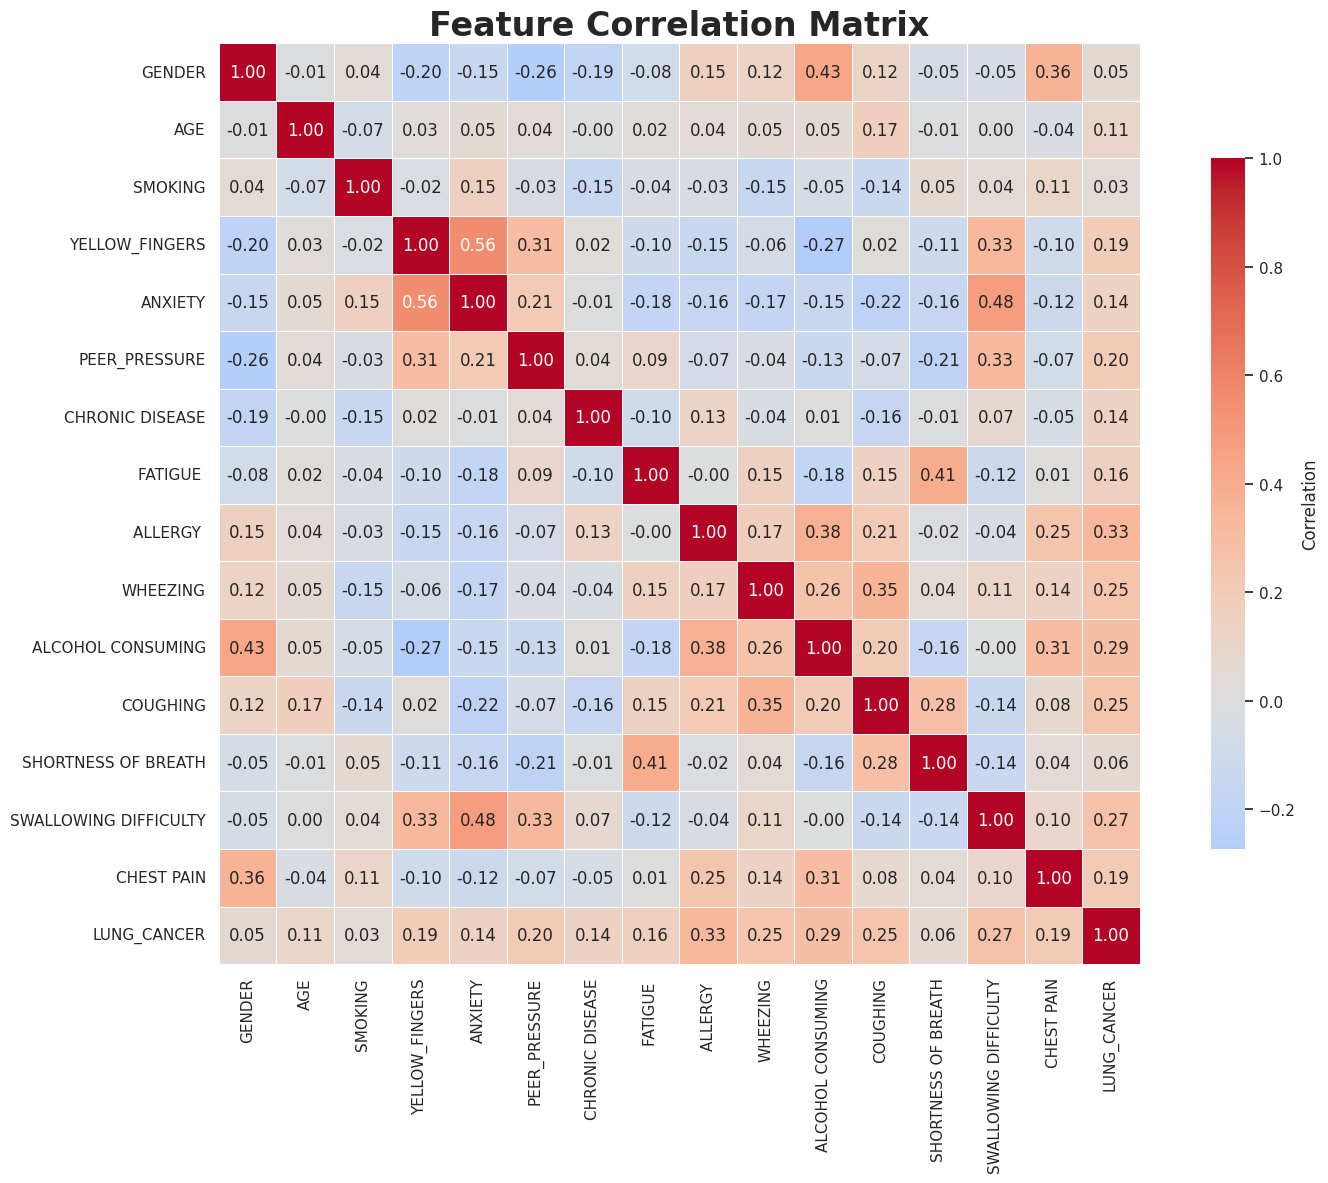

In [ ]:
# Finding correlation
cn = df.corr()

# Correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(
    data=cn,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75, "label": "Correlation"},
    annot=True,
    fmt=".2f",
)
plt.title("Feature Correlation Matrix", fontsize=24, weight="bold")
plt.tight_layout()
plt.show()


#### **Split Target Class & Class Balancing**
---

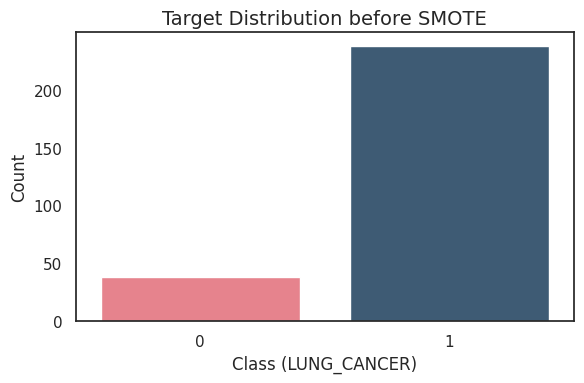


Sample number after SMOTE: 476 



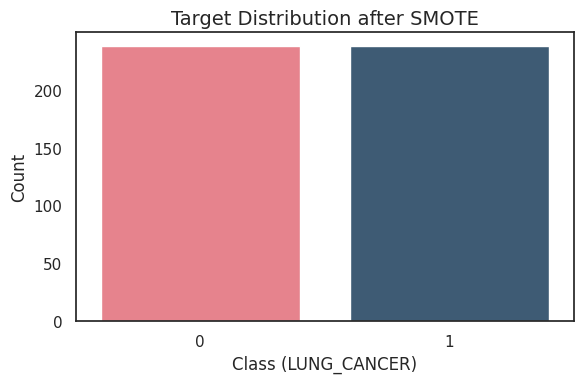

In [ ]:
# Splitting independent and dependent variables
X = df.drop("LUNG_CANCER", axis=1)
y = df["LUNG_CANCER"]  # Target Class

# Show target distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y, hue=y, palette=["#F67280", "#355C7D"], legend=False)
plt.title("Target Distribution before SMOTE", fontsize=14)
plt.xlabel("Class (LUNG_CANCER)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.tight_layout()
plt.show()

# Handling target distribution imbalance with SMOTE
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)
print("\nSample number after SMOTE:", len(X), "\n")

# Plotting target distribution after SMOTE
plt.figure(figsize=(6, 4))
sns.countplot(x=y, hue=y, palette=["#F67280", "#355C7D"], legend=False)
plt.title("Target Distribution after SMOTE", fontsize=14)
plt.xlabel("Class (LUNG_CANCER)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.tight_layout()
plt.show()

#### **Models Training and Evaluation**
---

In [ ]:
# Defining models
lr_model = LogisticRegression(max_iter=1000, random_state=100)
dt_model = DecisionTreeClassifier(random_state=100)
knn_model = KNeighborsClassifier()
gnb_model = GaussianNB()
mnb_model = MultinomialNB()
svm_model = SVC(probability=True, random_state=100)
rf_model = RandomForestClassifier(random_state=100)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=100)
mlp_model = MLPClassifier(max_iter=500, random_state=100)
gb_model = GradientBoostingClassifier(random_state=100)

models = [
    ("Logistic Regression", lr_model),
    ("Decision Tree", dt_model),
    ("KNN", knn_model),
    ("Gaussian NB", gnb_model),
    ("Multinomial NB", mnb_model),
    ("SVM", svm_model),
    ("Random Forest", rf_model),
    ("XGBoost", xgb_model),
    ("MLP", mlp_model),
    ("Gradient Boosting", gb_model),
]

# Stratified 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

scoring = {
    "Accuracy": "accuracy",
    "Precision": "precision_macro",
    "Recall": "recall_macro",
    "F1": "f1_macro",
    "MCC": "matthews_corrcoef",
    "ROC AUC": "roc_auc",
}

# Evaluate models with 5-Fold CV
print("\n--- Models Evaluation & Comparison (5-Fold Stratified Cross-Validation) ---\n")

results = []

for name, model in models:
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    mean_scores = {metric: round(np.mean(scores[f"test_{metric}"]), 3) for metric in scoring}
    mean_scores["Model"] = name
    results.append(mean_scores)

# Results
cv_df = pd.DataFrame(results).set_index("Model").sort_values(by="Accuracy", ascending=False)

print("Mean Metrics Results (Cross-Validation):\n")
print(cv_df)


--- Models Evaluation & Comparison (5-Fold Stratified Cross-Validation) ---

Mean Metrics Results (Cross-Validation):

                     Accuracy  Precision  Recall     F1    MCC  ROC AUC
Model                                                                  
Logistic Regression     0.960      0.961   0.960  0.960  0.921    0.988
Random Forest           0.950      0.952   0.950  0.950  0.901    0.984
MLP                     0.945      0.948   0.945  0.945  0.893    0.990
Gradient Boosting       0.941      0.944   0.941  0.941  0.885    0.978
XGBoost                 0.931      0.934   0.931  0.931  0.864    0.981
KNN                     0.924      0.927   0.924  0.924  0.851    0.969
Decision Tree           0.918      0.921   0.918  0.918  0.839    0.922
Gaussian NB             0.918      0.922   0.918  0.918  0.840    0.974
Multinomial NB          0.918      0.922   0.918  0.918  0.840    0.981
SVM                     0.630      0.638   0.630  0.621  0.268    0.728


## **Active Learning with HITL**

#### **Data Partition**
---

In [ ]:
# Data Partition: Fixed training set with 10 samples, test set 15%, validation set 15%, remaining for the pool set

# Remove test and validation sets (30% total --> 15% + 15%)
X_temp, X_val_test, y_temp, y_val_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=100
)

# Separate test and validation in two sets (half = 15% each)
X_validation, X_test, y_validation, y_test = train_test_split(
    X_val_test, y_val_test, test_size=0.5, stratify=y_val_test, random_state=100
)

# Select 10 samples for the training set, remaining for pool
X_train, X_pool, y_train, y_pool = train_test_split(
    X_temp, y_temp, stratify=y_temp, train_size=10, random_state=100
)

print("\n>>> Data Subsets")
print(f"Training: {len(X_train)} samples")
print(f"Pool (for AL loop): {len(X_pool)} samples")
print(f"Test: {len(X_test)} samples")
print(f"Validation: {len(X_validation)} samples\n")


>>> Data Subsets
Training: 10 samples
Pool (for AL loop): 323 samples
Test: 72 samples
Validation: 71 samples



#### **Query Strategies**
---

In [ ]:
# Least Confident - Uncertainty
def least_confident_sampling(model, X_pool, n_samples):
    probas = model.predict_proba(X_pool)
    uncertainty = 1 - np.max(probas, axis=1)
    return np.argsort(-uncertainty)[:n_samples]

# Margin Sampling - Uncertainty
def margin_sampling(model, X_pool, n_samples):
    probas = model.predict_proba(X_pool)
    sorted_probas = np.sort(probas, axis=1)[:, ::-1]
    margin = sorted_probas[:, 0] - sorted_probas[:, 1]
    return np.argsort(margin)[:n_samples]

# Hybrid Strategy - Margin (Uncertainty) + Kmeans (Diversity)
def margin_plus_diversity_sampling(model, X_pool, n_samples):
    """
    - Calculate uncertainty (margin)
    - Apply KMeans
    - From each cluster, select the sample with highest uncertainty
    """
    probas = model.predict_proba(X_pool)
    sorted_probas = np.sort(probas, axis=1)[:, ::-1]
    margin = sorted_probas[:, 0] - sorted_probas[:, 1]

    top_uncertain_idx = np.argsort(margin)[:min(n_samples * 3, len(X_pool))]
    uncertain_samples = X_pool[top_uncertain_idx]

    if len(uncertain_samples) <= n_samples:
        return top_uncertain_idx

    # KMeans for diversity
    kmeans = KMeans(n_clusters=n_samples, random_state=100, n_init=10).fit(uncertain_samples)
    selected_indices = []

    for i in range(n_samples):

        cluster_mask = kmeans.labels_ == i
        cluster_uncertainty = margin[top_uncertain_idx[cluster_mask]]
        most_uncertain_in_cluster = cluster_mask.nonzero()[0][np.argmin(cluster_uncertainty)]
        selected_indices.append(top_uncertain_idx[most_uncertain_in_cluster])

    return np.array(selected_indices)


strategies = {
    "Least Confident": least_confident_sampling,
    "Margin": margin_sampling,
    "Margin + Diversity": margin_plus_diversity_sampling,
}

#### **Stopping Criterion**
---

In [ ]:
# Stability based on Validation F1-Score

def check_stopping_criterion(f1_history, patience=5):
    """
    Stops the AL loop if, in the last N (patience) interactions,
    Validation F1-Score has not improved relative to the previous best result.
    """
    if len(f1_history) < patience + 1:
        return False

    best_f1 = max(f1_history[:-patience])
    recent_f1 = max(f1_history[-patience:])

    return recent_f1 <= best_f1

#### **Active Learning loop with Simulated HITL**
---

In [ ]:
class SimpleActiveLearner:
    def __init__(self, estimator, X_train, y_train):
        self.model = deepcopy(estimator)
        self.X_train = np.array(X_train)
        self.y_train = np.array(y_train)
        self.model.fit(self.X_train, self.y_train)

    def query(self, X_pool, strategy_func, n_samples):
        return strategy_func(self.model, X_pool, n_samples)

    def teach(self, X_new, y_new):
        self.X_train = np.vstack([self.X_train, X_new])
        self.y_train = np.concatenate([self.y_train, y_new])
        self.model.fit(self.X_train, self.y_train)

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        if hasattr(self.model, "predict_proba"):
            return self.model.predict_proba(X)
        return None

def calculate_metrics(model, X_test, y_test, X_val, y_val, iteration, model_name, strategy_name):
    preds_test = model.predict(X_test)
    preds_val = model.predict(X_val)

    return {
        "Iteration": iteration,
        "Model": model_name,
        "Strategy": strategy_name,
        "Test_F1": f1_score(y_test, preds_test, average="macro", zero_division=0),
        "Test_Accuracy": accuracy_score(y_test, preds_test),
        "Test_Precision": precision_score(y_test, preds_test, average="macro", zero_division=0),
        "Test_Recall": recall_score(y_test, preds_test, average="macro", zero_division=0),
        "Validation_F1": f1_score(y_val, preds_val, average="macro", zero_division=0),
        "Validation_Accuracy": accuracy_score(y_val, preds_val),
        "Validation_Precision": precision_score(y_val, preds_val, average="macro", zero_division=0),
        "Validation_Recall": recall_score(y_val, preds_val, average="macro", zero_division=0),
    }

def run_active_learning(model, model_name, strategy_func, strategy_name):
    print(f"\n>>> {model_name} - {strategy_name}")

    X_train_local = np.array(X_train)
    y_train_local = np.array(y_train)
    X_pool_local = np.array(X_pool)
    y_pool_local = np.array(y_pool)

    learner = SimpleActiveLearner(model, X_train_local, y_train_local)
    metrics_list = []
    f1_history = []

    # Iteration Configuration
    samples_per_iter = 10
    iteration = 0

    # Initial Metrics
    init_metrics = calculate_metrics(
        learner.model, X_test, y_test, X_validation, y_validation,
        iteration, model_name, strategy_name
    )
    metrics_list.append(init_metrics)
    f1_history.append(init_metrics["Validation_F1"])
    print(f"Iteration 0: Test F1={init_metrics['Test_F1']:.3f} | Validation F1={init_metrics['Validation_F1']:.3f}")

    while True:
        # Stops when the pool runs out of samples
        if len(X_pool_local) < samples_per_iter:
            print("Empty Pool - stopping loop.")
            break

        # Query (select samples from the pool and obtain their true labels)
        query_indices = learner.query(X_pool_local, strategy_func, samples_per_iter)
        X_new = X_pool_local[query_indices]
        y_new_true = y_pool_local[query_indices]

        iteration += 1
        print(f"\nIteration {iteration}: {len(X_new)} samples to label")

        # HITL and add selected samples to train set
        learner.teach(X_new, y_new_true)

        # Remove selected samples from pool
        X_pool_local = np.delete(X_pool_local, query_indices, axis=0)
        y_pool_local = np.delete(y_pool_local, query_indices, axis=0)

        # Metrics
        metrics = calculate_metrics(
            learner.model, X_test, y_test, X_validation, y_validation,
            iteration, model_name, strategy_name
        )
        metrics_list.append(metrics)
        f1_history.append(metrics["Validation_F1"])

        print(f"         Test F1={metrics['Test_F1']:.3f} | Validation F1={metrics['Validation_F1']:.3f}")

        # Add stopping criterion
        if check_stopping_criterion(f1_history):
            print("Stopping criterion met - stopping AL.")
            break

    return pd.DataFrame(metrics_list)

#### **Baseline Models**
---

In [ ]:
# Only trained with the initial training set

def create_baseline(model_original, model_name):
    print(f"\n>>> BASELINE: {model_name}")

    model = deepcopy(model_original)
    model.fit(X_train, y_train)
    metrics_baseline = calculate_metrics(model, X_test, y_test, X_validation, y_validation, 0, model_name, "Baseline")

    print(f"Baseline: F1 = {metrics_baseline['Validation_F1']:.3f}, Accuracy = {metrics_baseline['Validation_Accuracy']:.3f}")
    return pd.DataFrame([metrics_baseline])

#### **Active Learning Execution**
---

In [ ]:
# We use the 3 best models of the 5-fold CV according to F1-Score
selected_models = [lr_model, rf_model, mlp_model]
model_names = ["Logistic Regression", "Random Forest", "MLP"]

all_results = []
all_baselines = []

print("\n" + "="*60)
print("PHASE 1: BASELINE")
print("="*60)
for model, name in zip(selected_models, model_names):
    bas_df = create_baseline(model, name)
    all_baselines.append(bas_df)

baseline_df = pd.concat(all_baselines, ignore_index=True)

print("\n" + "="*60)
print("PHASE 2: ACTIVE LEARNING")
print("="*60)
for model, name in zip(selected_models, model_names):
    for strat_name, strat_func in strategies.items():
        df = run_active_learning(model, name, strat_func, strat_name)
        all_results.append(df)

results_df = pd.concat(all_results, ignore_index=True)

print("\n" + "="*70)
print("FINAL RESULTS")
print("="*70)

# Baseline
print("\n>>> BASELINE (only initial training set)\n")
baseline_table = baseline_df[[
    "Model", "Validation_F1", "Validation_Accuracy",
    "Validation_Precision", "Validation_Recall"
]].copy()

baseline_table.columns = [
    "Model", "F1", "Accuracy", "Precision", "Recall"
]

for col in ["F1", "Accuracy", "Precision", "Recall"]:
    baseline_table[col] = baseline_table[col].apply(lambda x: f"{x:.3f}" if x is not None else "N/A")

print(baseline_table.to_string(index=False))


# Active Learning
print("\n>>> ACTIVE LEARNING (resultados finais)\n")
al_results = []
for name in model_names:
    baseline_f1_rows = baseline_df[baseline_df["Model"] == name]
    baseline_f1 = baseline_f1_rows["Validation_F1"].values[0] if len(baseline_f1_rows) > 0 else 0

    for strat_name in strategies.keys():
        strat_rows = results_df[(results_df["Model"] == name) & (results_df["Strategy"] == strat_name)]
        if len(strat_rows) == 0:
            continue

        final_row = strat_rows.iloc[-1]
        al_f1 = final_row["Validation_F1"]
        al_acc = final_row["Validation_Accuracy"]

        improvement = ((al_f1 - baseline_f1) / baseline_f1 * 100) if baseline_f1 > 0 else 0
        status = "✓" if improvement > 0 else "✗"

        al_results.append({
            "Model": name,
            "Query Strategy": strat_name,
            "F1": f"{final_row['Validation_F1']:.3f}",
            "Accuracy": f"{final_row['Validation_Accuracy']:.3f}",
            "Precision": f"{final_row['Validation_Precision']:.3f}",
            "Recall": f"{final_row['Validation_Recall']:.3f}",
            "Improvement": f"{improvement:+.1f}%",
            "Status": status
        })

al_table = pd.DataFrame(al_results)
print(al_table.to_string(index=False))



PHASE 1: BASELINE

>>> BASELINE: Logistic Regression
Baseline: F1 = 0.619, Accuracy = 0.620

>>> BASELINE: Random Forest
Baseline: F1 = 0.813, Accuracy = 0.817

>>> BASELINE: MLP
Baseline: F1 = 0.816, Accuracy = 0.817

PHASE 2: ACTIVE LEARNING

>>> Logistic Regression - Least Confident
Iteration 0: Test F1=0.732 | Validation F1=0.619

Iteration 1: 10 samples to label
         Test F1=0.847 | Validation F1=0.845

Iteration 2: 10 samples to label
         Test F1=0.903 | Validation F1=0.901

Iteration 3: 10 samples to label
         Test F1=0.888 | Validation F1=0.929

Iteration 4: 10 samples to label
         Test F1=0.944 | Validation F1=0.901

Iteration 5: 10 samples to label
         Test F1=0.958 | Validation F1=0.930

Iteration 6: 10 samples to label
         Test F1=0.972 | Validation F1=0.930

Iteration 7: 10 samples to label
         Test F1=0.986 | Validation F1=0.972

Iteration 8: 10 samples to label
         Test F1=0.986 | Validation F1=0.972

Iteration 9: 10 samples to lab

#### **Learning Curve**
---


Saved figure: Figures/Logistic Regression_learning_curve.pdf



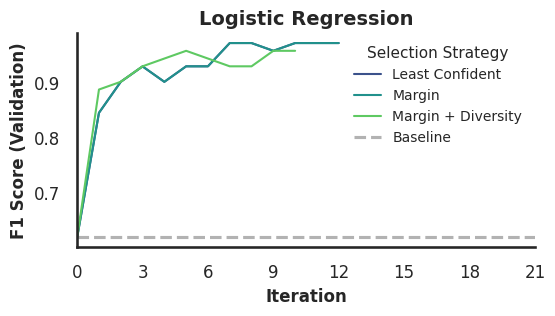


Saved figure: Figures/Random Forest_learning_curve.pdf



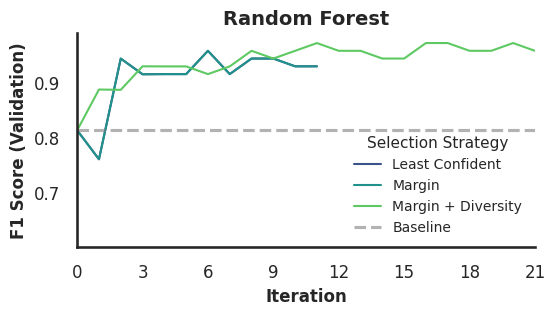


Saved figure: Figures/MLP_learning_curve.pdf



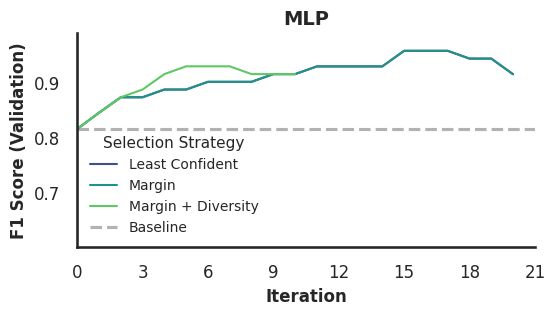

In [ ]:
def plot_learning_curves(df, model_names, strategies, baseline_df=None, save_dir=None):
    sns.set_theme(style="white", context="talk")
    os.makedirs(save_dir, exist_ok=True)

    palette = sns.color_palette("viridis", len(strategies))

    x_min, x_max = df["Iteration"].min(), df["Iteration"].max()
    y_min, y_max = df["Validation_F1"].min(), df["Validation_F1"].max()

    y_range = y_max - y_min
    y_min = max(0, y_min - 0.05 * y_range)
    y_max = y_max + 0.05 * y_range

    for model_name in model_names:
        fig, ax = plt.subplots(figsize=(6, 3.5))

        for j, strat in enumerate(strategies.keys()):
            subset = df[(df["Model"] == model_name) & (df["Strategy"] == strat)]
            if subset.empty:
                continue
            ax.plot(
                subset["Iteration"], subset["Validation_F1"],
                label=strat,
                linewidth=1.5,
                color=palette[j]
            )

        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        if baseline_df is not None and model_name in baseline_df["Model"].values:
            base_f1 = baseline_df[baseline_df["Model"] == model_name]["Validation_F1"].values[0]
            ax.axhline(base_f1, linestyle="--", color="gray", alpha=0.6, label="Baseline")

        ax.set_title(f"{model_name}", fontsize=14, weight="bold")
        ax.set_xlabel("Iteration", fontsize=12, weight="bold")
        ax.set_ylabel("F1 Score (Validation)", fontsize=12, weight="bold")
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
        ax.legend(fontsize=10, title="Selection Strategy", title_fontsize=11, frameon=False)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(False)
        ax.set_facecolor("white")

        plt.tight_layout()

        # Save figures
        if save_dir:
          os.makedirs(save_dir, exist_ok=True)
          save_path = os.path.join(save_dir, f"{model_name}_learning_curve.pdf")
          plt.savefig(save_path, dpi=300, bbox_inches="tight")
          print(f"\nSaved figure: {save_path}\n")

        plt.show()

# Plot Learning Curves
plot_learning_curves(
    df=results_df,
    model_names=model_names,
    strategies=strategies,
    baseline_df=baseline_df,
    save_dir="Figures"
)

#### **Improvement (AL *vs* Baseline)**
---

Saved figure: Figures/baseline_vs_al_grouped.pdf



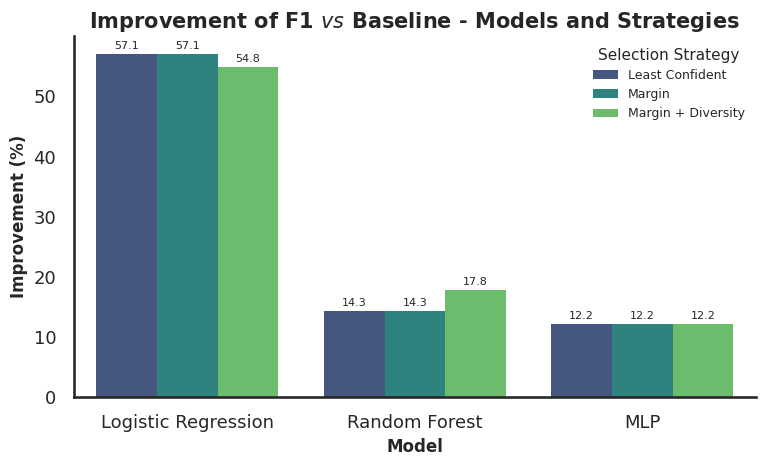

In [ ]:
def plot_baseline_vs_al_grouped(baseline_df, results_df, strategies, save_dir=None):
    sns.set_theme(style="white", context="talk")

    data = []

    for model_name in results_df["Model"].unique():
        baseline_f1 = baseline_df[baseline_df["Model"] == model_name]["Validation_F1"].values[0]

        for strat in strategies.keys():
            strat_rows = results_df[
                (results_df["Model"] == model_name) & (results_df["Strategy"] == strat)
            ]
            if strat_rows.empty:
                continue
            last_iter = strat_rows.iloc[-1]
            imp = ((last_iter["Validation_F1"] - baseline_f1) / baseline_f1) * 100
            data.append({"Modelo": model_name, "Estratégia": strat, "Melhoria (%)": imp})

    df_plot = pd.DataFrame(data)

    palette = sns.color_palette("viridis", len(strategies))

    plt.figure(figsize=(8, 5))
    ax = sns.barplot(
        x="Modelo", y="Melhoria (%)", hue="Estratégia",
        data=df_plot, palette=palette, edgecolor="none"
    )

    ax.set_title(r"Improvement of F1 $\it{vs}$ Baseline - Models and Strategies", fontsize=15, fontweight="bold")
    ax.set_xlabel("Model", fontsize=12, fontweight="bold")
    ax.set_ylabel("Improvement (%)", fontsize=12, fontweight="bold")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_facecolor("white")
    ax.grid(False)
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)

    for container in ax.containers:
        ax.bar_label(container, fmt="%.1f", fontsize=8, padding=2)

    plt.legend(
        title="Selection Strategy",
        title_fontsize=11,
        fontsize=9,
        frameon=False
    )

    plt.tight_layout()

    # Save figure
    if save_dir:
      os.makedirs(save_dir, exist_ok=True)
      save_path = os.path.join(save_dir, "baseline_vs_al_grouped.pdf")
      plt.savefig(save_path, dpi=300, bbox_inches="tight")
      print(f"Saved figure: {save_path}\n")

    plt.show()

# Plot Bar Plot
plot_baseline_vs_al_grouped(baseline_df, results_df, strategies, save_dir="Figures")

#### **Stability Plot**
---

Saved figure: Figures/stability_curve.pdf



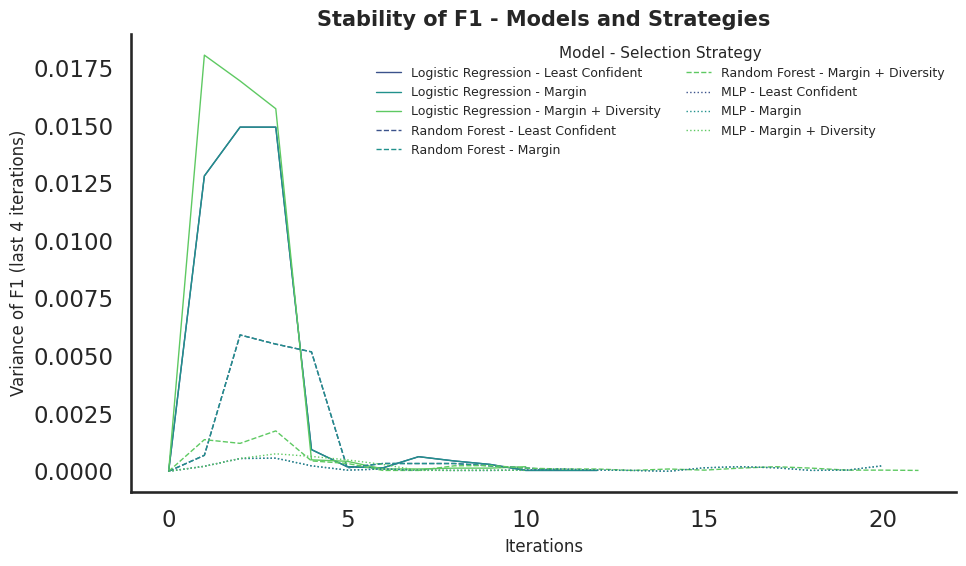

In [ ]:
def plot_stability_all(df, strategies, save_dir=None):
    sns.set_theme(style="white", context="talk")
    models = df["Model"].unique()
    strategy_names = list(strategies.keys())
    palette = sns.color_palette("viridis", len(strategy_names))

    linestyles = ['-', '--', ':']

    plt.figure(figsize=(10, 6))

    for i, model_name in enumerate(models):
        for j, strat in enumerate(strategy_names):
            subset = df[(df["Model"] == model_name) & (df["Strategy"] == strat)]
            if subset.empty:
                continue

            f1_vals = subset["Validation_F1"].values
            variances = [np.var(f1_vals[max(0, k - 3):k + 1]) for k in range(len(f1_vals))]

            plt.plot(
                subset["Iteration"],
                variances,
                linewidth=1,
                linestyle=linestyles[i % len(linestyles)],
                label=f"{model_name} - {strat}",
                color=palette[j]
            )

    plt.title("Stability of F1 - Models and Strategies", fontsize=15, weight="bold")
    plt.xlabel("Iterations", fontsize=12)
    plt.ylabel("Variance of F1 (last 4 iterations)", fontsize=12)
    plt.legend(
        fontsize=9,
        title="Model - Selection Strategy",
        title_fontsize=11,
        ncol=2,
        frameon=False
    )
    plt.grid(False)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.tight_layout()

    # Save figure
    if save_dir:
      os.makedirs(save_dir, exist_ok=True)
      save_path = os.path.join(save_dir, "stability_curve.pdf")
      plt.savefig(save_path, dpi=300, bbox_inches="tight")
      print(f"Saved figure: {save_path}\n")

    plt.show()

# Plot Stability Curve
plot_stability_all(results_df, strategies, save_dir="Figures")

## **Explainability**

#### **SHAP**
---

  0%|          | 0/71 [00:00<?, ?it/s]

/tmp/ipython-input-3739239271.py:16: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv.values, X_validation, show=False)


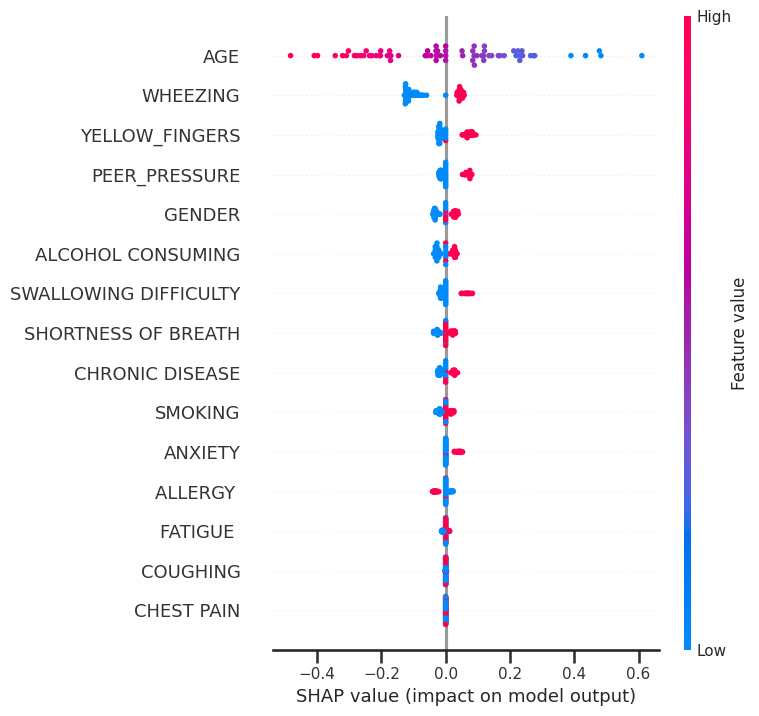

/tmp/ipython-input-3739239271.py:23: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv.values, X_validation, plot_type='bar', show=False)


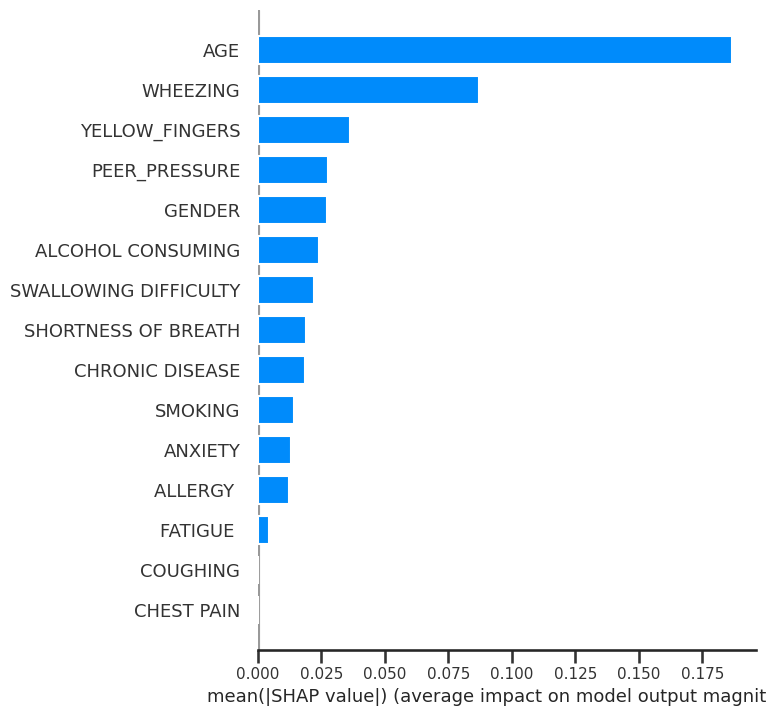

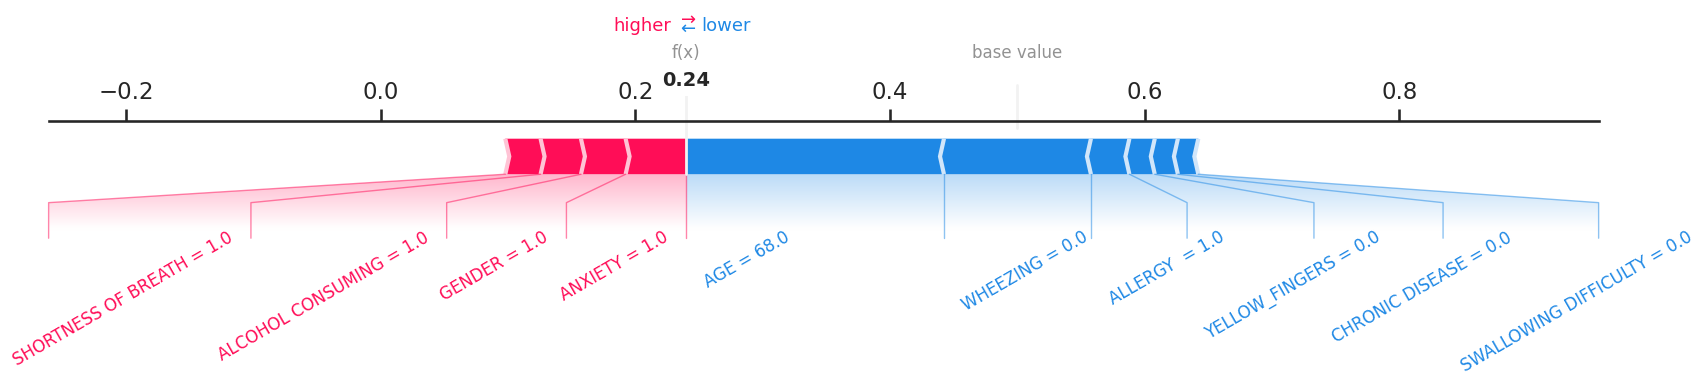

In [ ]:
os.makedirs("Figures", exist_ok=True)

# Fit logistic regression
lr_model.fit(X_train, y_train)

# Initialize SHAP JS
shap.initjs()

# SHAP Explainer
explainer = shap.KernelExplainer(lr_model.predict_proba, X_train)
shap_values = explainer(X_validation)
sv = shap_values[..., 1]

# Summary plot (dot)
plt.figure(figsize=(10,8))
shap.summary_plot(sv.values, X_validation, show=False)
plt.savefig("Figures/shap_summary_plot.pdf", format='pdf', bbox_inches='tight')
plt.show()
plt.close()

# Summary plot (bar)
plt.figure(figsize=(10,8))
shap.summary_plot(sv.values, X_validation, plot_type='bar', show=False)
plt.savefig("Figures/shap_summary_bar_plot.pdf", format='pdf', bbox_inches='tight')
plt.show()
plt.close()

# Force plot
idx = 0
shap.force_plot(
    explainer.expected_value[1],
    sv.values[idx],
    X_validation.iloc[idx],
    matplotlib=True,
    show=True,
    text_rotation=30
)

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

# Features and Classes
feature_names = list(X_train.columns)
class_names = ["No Cancer", "Cancer"]
X_train_np = X_train.values
X_test_np = X_test.values

# LIME explainer
lime_explainer = LimeTabularExplainer(
    training_data=X_train_np,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

def explain_with_lime(model, model_name, sample_index=0):
    print(f"LIME Explanation for: {model_name}")

    instance = X_test_np[sample_index]

    # Explanation
    explanation = lime_explainer.explain_instance(
        data_row=instance,
        predict_fn=model.predict_proba,
        num_features=10
    )

    explanation.show_in_notebook(show_table=True)

    # Probabilities
    print("Predicted Probabilities:")
    print(model.predict_proba([instance])[0])

# Treina o modelo
lr_model.fit(X_train, y_train)
explain_with_lime(lr_model, "Logistic Regression", sample_index=0)

LIME Explanation for: Logistic Regression


Predicted Probabilities:
[0.71196632 0.28803368]
